# Lab - End-to-end Machine Learning

### Dataset

Vamos trabalhar com dataset de e-commerce da [Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).

Neste dataset temos informações de ordens, entrega, localizações, reviews, preços e etc

### Hipótese

**Será que podemos prever qual rating que o cliente dará ao serviço?**

Quais os motivos para que um pedido seja mal avaliado?

1.   Atraso na entrega
2.   Pedido veio errado, com defeito ou não satisfez a necessidade do cliente

### O Fluxo de Modelagem:

Este fluxo deve ser cíclico, ou seja, devemos repetir os passos até chegar na performance adequada do modelo.

1. Construção do Dataset
  * Join / Merge com as tabelas e construção de uma base analítica
  * Limpeza e pré-processamento da base
2. EDA
  * Uma análise minuciosa dos dados que será insumo para feature engineering e modelagem


Neste notebook, vamos simplificar todas estas etapas, como por exemplo a EDA. Porém, cabe a cada um aprimorar este pipeline para encontrar melhores modelos, como por exemplo: testar diferentes tipos de feature engineering, encoding e modelos.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import warnings

from pathlib import Path
import pickle
warnings.filterwarnings('ignore')

# Importando libs de plots
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
# sns.set_context('talk')
sns.set_palette('rainbow')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## Construção do Dataset

### Leitura

Vamos ler todos os CSVs do dataset e fazer os merges necessários

In [2]:
path = "data/"

df_o = pd.read_csv(path+'olist_orders_dataset.csv', parse_dates = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',	'order_delivered_customer_date',	'order_estimated_delivery_date'])
df_oi = pd.read_csv(path+'olist_order_items_dataset.csv', parse_dates = ['shipping_limit_date'])
df_op = pd.read_csv(path+'olist_order_payments_dataset.csv')
df_or = pd.read_csv(path+'olist_order_reviews_dataset.csv')
df_p = pd.read_csv(path+'olist_products_dataset.csv')
df_s = pd.read_csv(path+'olist_sellers_dataset.csv')
df_c = pd.read_csv(path+'olist_customers_dataset.csv')
df_l = pd.read_csv(path+'olist_geolocation_dataset.csv')
df_pc = pd.read_csv(path+'product_category_name_translation.csv')

In [3]:
df_l_grouped = df_l.groupby('geolocation_zip_code_prefix')[['geolocation_lat',	'geolocation_lng'	]].mean().reset_index()

### Merges

In [4]:
df_o = pd.merge(left = df_o, right = df_c, on = ['customer_id'], how = 'left')
df_o = pd.merge(left = df_o, right = df_op.groupby('order_id')['payment_value'].sum(), on = ['order_id'], how = 'left')
df_o = pd.merge(left = df_o, right = df_or.groupby('order_id')['review_score'].mean().reset_index(),
                on = ['order_id'],
                how = 'left')
df_o = pd.merge(left = df_o,
                right = df_l_grouped.rename(columns = {'geolocation_lat' : 'c_lat',	'geolocation_lng' : 'c_lng'}),
                left_on = 'customer_zip_code_prefix',
                right_on = 'geolocation_zip_code_prefix',
                how = 'left')

df_oi = pd.merge(left = df_oi, right = df_p, on = ['product_id'], how = 'left')
df_oi = pd.merge(left = df_oi, right = df_s, on = ['seller_id'], how = 'left')
df_oi = pd.merge(left = df_oi,
                 right = df_l_grouped.rename(columns = {'geolocation_lat' : 's_lat',	'geolocation_lng' : 's_lng'}),
                 left_on = 'seller_zip_code_prefix',
                 right_on = 'geolocation_zip_code_prefix',
                 how = 'left')

In [5]:
df_o.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_value,review_score,geolocation_zip_code_prefix,c_lat,c_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,38.71,4.0,3149.0,-23.576983,-46.587161
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,141.46,4.0,47813.0,-12.177924,-44.660711
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,179.12,5.0,75265.0,-16.745150,-48.514783
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,72.20,5.0,59296.0,-5.774190,-35.271143
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,28.62,5.0,9195.0,-23.676370,-46.514627


In [6]:
df_oi.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,s_lat,s_lng
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP,27277.0,-22.496953,-44.127492
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,3471,sao paulo,SP,3471.0,-23.565096,-46.518565
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,37564,borda da mata,MG,37564.0,-22.262584,-46.171124
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,14403,franca,SP,14403.0,-20.553624,-47.387359
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,87900,loanda,PR,87900.0,-22.929384,-53.135873


In [7]:
df = pd.merge(left = df_oi, right = df_o, on = ['order_id'], how = 'left')

df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix_x,s_lat,s_lng,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_value,review_score,geolocation_zip_code_prefix_y,c_lat,c_lng
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP,27277.0,-22.496953,-44.127492,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,72.19,5.0,28013.0,-21.762775,-41.309633
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,3471,sao paulo,SP,3471.0,-23.565096,-46.518565,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,259.83,4.0,15775.0,-20.220527,-50.903424
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,37564,borda da mata,MG,37564.0,-22.262584,-46.171124,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,216.87,5.0,35661.0,-19.870305,-44.593326
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,14403,franca,SP,14403.0,-20.553624,-47.387359,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,25.78,4.0,12952.0,-23.089925,-46.611654
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,87900,loanda,PR,87900.0,-22.929384,-53.135873,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,218.04,5.0,13226.0,-23.243402,-46.827614


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112650 non-null  object        
 1   order_item_id                  112650 non-null  int64         
 2   product_id                     112650 non-null  object        
 3   seller_id                      112650 non-null  object        
 4   shipping_limit_date            112650 non-null  datetime64[ns]
 5   price                          112650 non-null  float64       
 6   freight_value                  112650 non-null  float64       
 7   product_category_name          111047 non-null  object        
 8   product_name_lenght            111047 non-null  float64       
 9   product_description_lenght     111047 non-null  float64       
 10  product_photos_qty             111047 non-null  float64       
 11  

## EDA


In [9]:
df["review_score"].value_counts()

review_score
5.000000    63082
4.000000    21166
1.000000    14079
3.000000     9384
2.000000     3833
4.500000       68
2.500000       45
3.500000       31
1.500000       18
3.333333        1
4.333333        1
Name: count, dtype: int64

In [10]:
(df["review_score"] >= 4).value_counts(normalize=True)

review_score
True     0.748486
False    0.251514
Name: proportion, dtype: float64

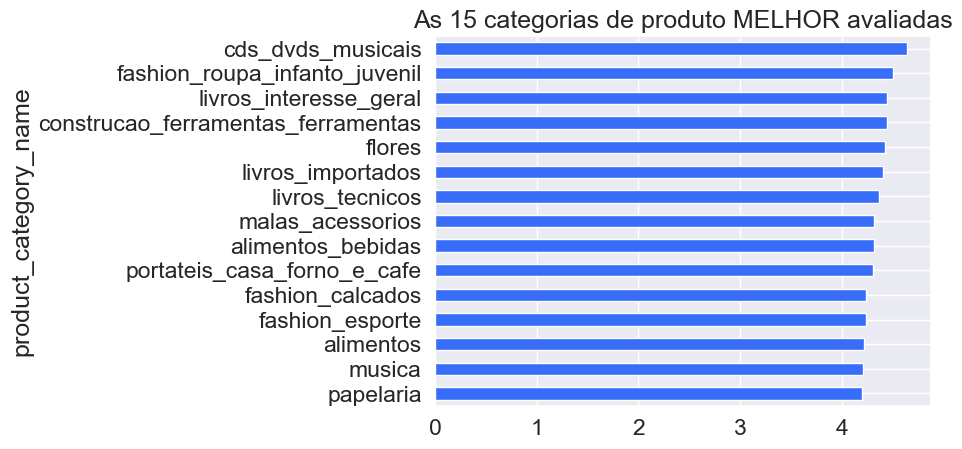

In [11]:
plt.title("As 15 categorias de produto MELHOR avaliadas")
df.groupby("product_category_name")["review_score"].agg("mean").sort_values(ascending=True)[-15:].plot(kind="barh",)
plt.show()

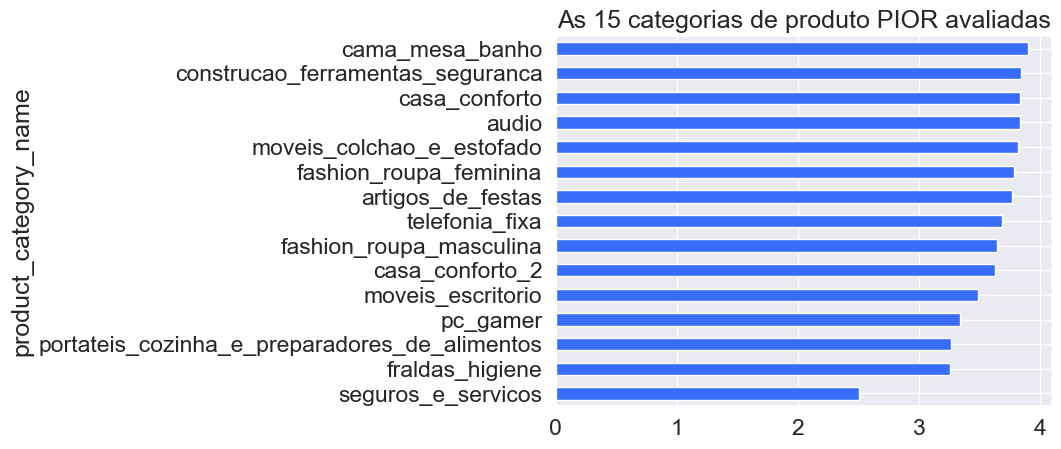

In [12]:
plt.title("As 15 categorias de produto PIOR avaliadas")
df.groupby("product_category_name")["review_score"].agg("mean").sort_values(ascending=True)[:15].plot(kind="barh",)
plt.show()

In [13]:
df[["price", "freight_value"]].describe()

,price,freight_value
count,112650.000000,112650.000000
mean,120.653739,19.990320
std,183.633928,15.806405
min,0.850000,0.000000
25%,39.900000,13.080000
50%,74.990000,16.260000
75%,134.900000,21.150000
max,6735.000000,409.680000


In [14]:
df_eda = df.copy()

df_eda["full_price"] = df["price"] + df["freight_value"]
df_eda["full_price"].describe().to_frame()

,full_price
count,112650.000000
mean,140.644059
std,190.724394
min,6.080000
25%,55.220000
50%,92.320000
75%,157.937500
max,6929.310000


In [15]:
df_eda[["price", "freight_value", "review_score"]].corr()

,price,freight_value,review_score
price,1.000000,0.414204,-0.004081
freight_value,0.414204,1.000000,-0.036363
review_score,-0.004081,-0.036363,1.000000
